In [87]:
import math
import numpy as np
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from sklearn.metrics import roc_curve, auc, confusion_matrix
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy import stats
import seaborn
%matplotlib inline

In [65]:
def doNumber(data_EC, data_Layer, data_number, data_true):

    data = {}

    outdata = np.zeros(
        (data_number.shape[0],),
        dtype=[
            ('Output_number', np.dtype(('f4', 3))),
            ('Output_number_true', 'i4'),
            ('Output_number_estimated', 'i4')
        ]
    )
    outdata['Output_number'] = data_number
    outdata['Output_number_true'] = data_true

    truth0Particles = outdata['Output_number_true']==0
    splitParticles = outdata['Output_number'][:,0]>=0.9999
    deleted = np.logical_or(truth0Particles, splitParticles)

    outdata = np.delete(outdata, np.where(deleted))
    data_Layer = np.delete(data_Layer, np.where(deleted))
    data_EC = np.delete(data_EC, np.where(deleted))

    IBL = np.logical_and(data_Layer == 0, data_EC == 0)
    Barrel = np.logical_and(data_Layer > 0, data_EC == 0)
    Endcap = data_EC != 0

    data['IBL'] = outdata[IBL]
    data['Barrel'] = outdata[Barrel]
    data['Endcap'] = outdata[Endcap]
    return data

In [5]:
def plot_confusion_matrix(data, accuracy, labels, title, output_filename, layer):

    plt.style.use('seaborn')
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
    plt.title(f'Confusion Matrix for {title} {layer}', fontdict = {'fontsize' : 14})
 
    seaborn.set(font_scale=1.4)
    ax = seaborn.heatmap(data, vmin=0, vmax=1, annot=True, cmap="Greys", cbar_kws={'label': 'Cluster Density'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")

    ax.text(1, 1, f'Accuracy = {accuracy:.2f}', size='12',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)
 
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.close()
    plt.rcParams.update(plt.rcParamsDefault)

In [67]:
def doMatrix(matrix):
    matrix = matrix / np.sum(matrix, axis=1, keepdims=True)
    total = float(np.sum(matrix))
    correct = float(np.sum(np.diag(matrix)))
    accuracy = correct / total
    return accuracy, matrix

def doConfusion(data, title, outpath):
    for layer in data:
        matrix = confusion_matrix(data[layer]['Output_number_true'], data[layer]['Output_number_estimated'], labels=[1,2,3])
        accuracy, matrix = doMatrix(matrix)
        plot_confusion_matrix(matrix, accuracy, ['1', '2', '3'], title, f'{outpath}{title}_{layer}_confusion.png'.replace(" ", "_"), layer)

    matrix = confusion_matrix(np.concatenate([data[x] for x in data])['Output_number_true'], \
                np.concatenate([data[x] for x in data])['Output_number_estimated'], labels=[1,2,3])
    accuracy, matrix = doMatrix(matrix)
    plot_confusion_matrix(matrix, accuracy, ['1', '2', '3'], title, f'{outpath}{title}_total_confusion.png'.replace(" ", "_"), 'All Layers')

In [69]:
def doValueEstimation(data, thrsh):
    for layer in data:
        value = data[layer]['Output_number'][:,0] * 1 + \
                data[layer]['Output_number'][:,1] * 2 + \
                data[layer]['Output_number'][:,2] * 3
        data[layer]['Output_number_estimated'] = 1
        data[layer]['Output_number_estimated'][
            np.where(value>thrsh[layer][0])
        ] = 2
        data[layer]['Output_number_estimated'][
            np.where(value>thrsh[layer][1])
        ] = 3
    return data

def doMaxEstimation(data):
    for layer in data:
        data[layer]['Output_number_estimated'] = np.argmax(data[layer]['Output_number'], axis=1) + 1
    return data
    
def doThresholdEstimation(data, thrsh):
    for layer in data:
        data[layer]['Output_number_estimated'][
            np.where(np.logical_and(data[layer]['Output_number'][:,1] < thrsh[layer][0], data[layer]['Output_number'][:,2] < thrsh[layer][1]))
        ] = 1
        data[layer]['Output_number_estimated'][
            np.where(np.logical_and(data[layer]['Output_number'][:,1] >= thrsh[layer][0], data[layer]['Output_number'][:,2] < thrsh[layer][1]))
        ] = 2
        data[layer]['Output_number_estimated'][
            np.where(data[layer]['Output_number'][:,2] >= thrsh[layer][1])
        ] = 3
    return data
        

In [29]:
def loadData(path):
    with h5.File(path, 'r') as data:
        data_x = data['input'][()]
        data_Layer = data_x[:,0]
        data_EC = data_x[:,1]
        data_true = data_x[:,2]
        data_2pr = data_x[:,3]
        data_3pr = data_x[:,4]
        data_1pr = 1-data_2pr-data_3pr
        data_number = np.ndarray((data_1pr.shape[0],3))
        data_number[:,0] = data_1pr
        data_number[:,1] = data_2pr
        data_number[:,2] = data_3pr
    data = doNumber(data_EC, data_Layer, data_number, data_true)
    return data

In [81]:
def applyThreshold(data, layer, thrs):
    data[layer]['Output_number_estimated'][
        np.where(np.logical_and(data[layer]['Output_number'][:,1] < thrs[0], data[layer]['Output_number'][:,2] < thrs[1]))
    ] = 1
    data[layer]['Output_number_estimated'][
        np.where(np.logical_and(data[layer]['Output_number'][:,1] >= thrs[0], data[layer]['Output_number'][:,2] < thrs[1]))
    ] = 2
    data[layer]['Output_number_estimated'][
        np.where(data[layer]['Output_number'][:,2] >= thrs[1])
    ] = 3

    matrix = confusion_matrix(data[layer]['Output_number_true'], data[layer]['Output_number_estimated'], labels=[1,2,3])
    return matrix

def doAccuracy(matrix, weighted):
    if weighted:
        matrix = matrix / np.sum(matrix, axis=1, keepdims=True)
    total = float(np.sum(matrix))
    correct = float(np.sum(np.diag(matrix)))
    accuracy = correct / total
    return accuracy

def findThresh(min, max, steps, weighted):
    bestThresh = {'IBL' : [0,0], 'Barrel' : [0,0], 'Endcap' : [0,0]}
    x = np.linspace(min, max, steps)
    y = np.linspace(min, max, steps)
    z = {'IBL' : np.empty([x.size, y.size]), 'Barrel' : np.empty([x.size, y.size]), 'Endcap' : np.empty([x.size, y.size])}
    for k, layer in enumerate(data):
        accuracy = 0
        for i in range(x.size):
            for j in range(y.size):
                thrs = [x[i], y[j]]
                matrix = applyThreshold(data, layer, thrs)                
                tempAccuracy = doAccuracy(matrix, weighted)
                z[layer][i][j] = tempAccuracy
                if accuracy > tempAccuracy:
                    pass
                else:
                    bestThresh[layer] = thrs
                    accuracy = tempAccuracy

        bestThresh[layer][0] = round(bestThresh[layer][0], 2)
        bestThresh[layer][1] = round(bestThresh[layer][1], 2)
        print(f"Best Threshold for {layer}: {bestThresh[layer]}, with accuracy: {accuracy:.3f}")
    print(f"Best Threshold: {bestThresh}")
    return x, y, z, bestThresh

In [9]:
def _2dhist():
    for i in range(1, 4):
        isel = np.where(data['IBL']['Output_number_true'] == i)
        x = data['IBL']['Output_number'][isel][:,1]
        y = data['IBL']['Output_number'][isel][:,2]

        plt.hist2d(x, y, bins=(100,100), norm=mcolors.LogNorm())
        plt.title(f'Distribution for {i} particle clusters')
        plt.xlabel('2 Particle Confidence')
        plt.xlabel('3 Particle Confidence')
        cbar = plt.colorbar()
        cbar.set_label('')
        plt.show()
        plt.close()

In [119]:
def accuracyPlots(x, y, z):
    for layer in z:
        if numpy.isnan(z[layer][0][0]):
            pass
        else:
            plt.pcolormesh(x, y, z[layer], cmap=cm.coolwarm)
            plt.colorbar()
            plt.title(f'{layer} Accuracy')
            plt.xlabel('Threshold 1')
            plt.ylabel('Threshold 2')
            plt.show()

def plotValue(data, title):
    for layer in data:
        print(f'Layer: {layer}')
        for i in range(3):
            bins = np.linspace(1, 3, 200)
            iTruth = data[layer][data[layer]['Output_number_true']==i+1]
            value = np.zeros(iTruth.size)
            for j in range(3):
                value += iTruth['Output_number'][:,j]*(j+1)
            print(f'Value when truth {i+1}: {np.mean(value)}')
            plt.hist(value, bins, alpha=0.5, label=f'{i+1} Particle Value', density=True)
            plt.legend(loc='upper right')
        plt.title(f'Value Distribution for {title} {layer}')
        plt.xlabel('Particle Value')
        plt.ylabel('Normalized Count')
        plt.show()
        print('')

## Default Threshold Method

In [93]:
data = loadData('data/dijet7w.h5')
x, y, z, bestThresh = findThresh(0.21, 0.7, 50, True)
outpath = "output/Cutoff/"
data = doThresholdEstimation(data, bestThresh)
doConfusion(data, 'Threshold Dijet7w', outpath)
showAccuracyPlot(x, y, z)


Best Threshold for IBL: [0.5, 0.4], with accuracy: 0.7778999578713611
Best Threshold for Barrel: [0.5, 0.5], with accuracy: 0.781260896143653
Best Threshold for Endcap: [1.0, 1.0], with accuracy: nan
Best Threshold: {'IBL': [0.5, 0.4], 'Barrel': [0.5, 0.5], 'Endcap': [1.0, 1.0]}
Done!


In [ ]:
data = loadData('data/ttbar.h5')
x, y, z, bestThresh = findThresh(0.21, 0.7, 50, True)
outpath = "output/Cutoff/"
data = doThresholdEstimation(data, bestThresh)
doConfusion(data, 'Threshold ttbar', outpath)
showAccuracyPlot(x, y, z)

## Max Threshold Method

In [ ]:
data = loadData('data/dijet7w.h5')
outpath = "output/Cutoff/"
data = doValueEstimation(data)
doConfusion(data, 'Max Dijet7w', outpath)

In [ ]:
data = loadData('data/ttbar.h5')
outpath = "output/Cutoff/"
data = doValueEstimation(data)
doConfusion(data, 'Max ttbar', outpath)

## Value Threshold Method

Layer: IBL
Value when truth 1: 1.228489956082997
Value when truth 2: 2.1149696193281367
Value when truth 3: 2.6751602100674257


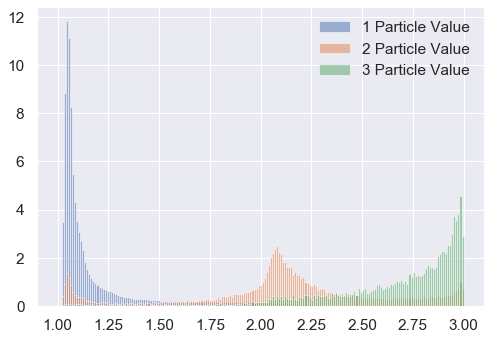


Layer: Barrel
Value when truth 1: 1.2235134529961236
Value when truth 2: 2.194838431317331
Value when truth 3: 2.7406778766108797


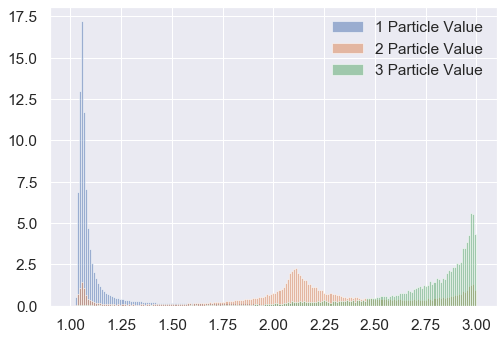


Layer: Endcap
Value when truth 1: 1.3762701969688311
Value when truth 2: 1.9965583505108953
Value when truth 3: nan


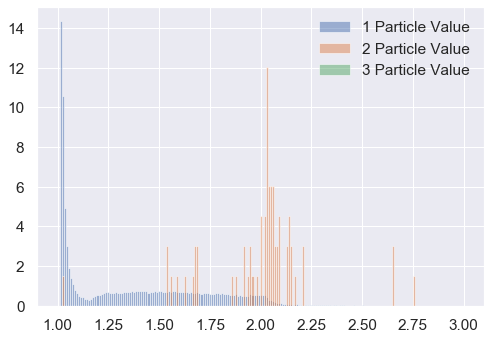

In [74]:
data = loadData('data/dijet7w.h5')
plotValue(data, 'Dijet7w')

In [ ]:
data = loadData('data/ttbar.h5')
plotValue(data)

In [ ]:
data = loadData('data/dijet7w.h5')
outpath = "output/Cutoff/"
valueThresh = {'IBL':[1.5, 2.5], 'Barrel':[1.5, 2.5], 'Endcap':[1.5, 2.5]}
data = doValueEstimation(data, valueThresh)
doConfusion(data, 'ValueThresh Dijet7w', outpath)=

In [ ]:
data = loadData('data/ttbar.h5')
outpath = "output/Cutoff/"
valueThresh = {'IBL':[1.5, 2.5], 'Barrel':[1.5, 2.5], 'Endcap':[1.5, 2.5]}
data = doValueEstimation(data, valueThresh)
doConfusion(data, 'ValueThresh ttbar', outpath)=

In [11]:
'''
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
data = loadData('data/dijet7w.h5')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for layer in data:
    print(f'Layer: {layer}')
    for i in range(3):
        dist = []
        mean = np.array([0.0, 0.0, 0.0])
        bins = np.linspace(0, 1, 100)

        for j in range(3):
            prob = data[layer][data[layer]['Output_number_true']==i+1]['Output_number'][:,j]
            mean[j] = np.mean(prob)
            std = np.std(prob)
            #a1, b1, loc1, scale1 = stats.beta.fit(prob)
            #plt.hist(prob, bins, alpha=0.5, label=f'{j+1} Particle Confidence', density=True, color=colors[j])
            #pdf = stats.beta.pdf(bins, a1, b1, loc1, scale1)
            #plt.plot(bins, pdf, color=colors[j])
            dist.append(prob)
        print(f'Probability when truth {i+1}: {mean}')
        #plt.legend(loc='upper right')
        #plt.ylim(0,15)
        #plt.show()
        print('')
    print('')
    '''

Layer: IBL
Probability when truth 1: [0.80 0.16 0.03]

Probability when truth 2: [0.16 0.58 0.26]

Probability when truth 3: [0.04 0.28 0.68]


Layer: Barrel
Probability when truth 1: [0.82 0.14 0.04]

Probability when truth 2: [0.15 0.52 0.32]

Probability when truth 3: [0.06 0.22 0.72]


Layer: Endcap
Probability when truth 1: [0.64 0.35 0.01]

Probability when truth 2: [0.11 0.80 0.09]

Probability when truth 3: [nan nan nan]


